In [38]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [39]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/amazon_cells_labelled.txt

--2022-04-08 09:57:34--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/amazon_cells_labelled.txt
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.143.34
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.143.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58226 (57K) [text/plain]
Saving to: ‘amazon_cells_labelled.txt.1’

amazon_cells_labell 100%[===================>]  56.86K   369KB/s    in 0.2s    

2022-04-08 09:57:35 (369 KB/s) - ‘amazon_cells_labelled.txt.1’ saved [58226/58226]



In [40]:
df = pd.read_csv('amazon_cells_labelled.txt', sep ='\t', header = None, names = ['reviews', 'sentiment'])

In [41]:
df

,reviews,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


In [42]:
df['reviews'].to_list()

['So there is no way for me to plug it in here in the US unless I go by a converter.',
 'Good case, Excellent value.',
 'Great for the jawbone.',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!',
 'The mic is great.',
 'I have to jiggle the plug to get it to line up right to get decent volume.',
 'If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.',
 'If you are Razr owner...you must have this!',
 'Needless to say, I wasted my money.',
 'What a waste of money and time!.',
 'And the sound quality is great.',
 'He was very impressed when going from the original battery to the extended battery.',
 'If the two were seperated by a mere 5+ ft I started to notice excessive static and garbled sound from the headset.',
 'Very good quality though',
 'The design is very odd, as the ear "clip" is not very comfortable at all.',
 'Highly recommend for any one who has a blue tooth phone.',
 'I advise EVERYO

In [43]:
# FUNZIONE CHE MI AGGREGA TUTTI COMANDI DI REGEX PER IL DATA CLEANING
import re

def clean_special_patterns(text):
    """Remove special patterns - email, url, date etc."""
    html_regex = re.compile(r"<.*?>")
    email_regex = re.compile(r"[\w.-]+@[\w.-]+")
    url_regex = re.compile(r"(http|www)[^\s]+")
    date_regex = re.compile(r"[\d]{2,4}[ -/:]*[\d]{2,4}([ -/:]*[\d]{2,4})?") # a way to match date
    new_line = re.compile(r"/(\r\n)+|\r+|\n+|\t+/")
    number = re.compile(r"[\d+]")
    under = re.compile(r"[^a-zA-Z0-9:$-,%.?!]+")
    simbols = re.compile(r"[^\w\s/'/`]")
    spaces = re.compile(r"\s{2,}")
    remove_singlelett= re.compile(r"(^| ).( |$)")

    ## remove
    text = text.lower()
    text = number.sub(" ", text)
    text = html_regex.sub(" ", text)
    text = url_regex.sub(" ", text)
    text = email_regex.sub(" ", text)
    text = date_regex.sub(" ", text)
    text = new_line.sub(" ", text)
    text = under.sub(" ", text)
    text = simbols.sub(" ", text)
    text = spaces.sub(" ", text)
    text = text.replace("`", "'")
    text = remove_singlelett.sub("",text)
    return text

In [44]:
# APPLICO LA FUNZIONE SU TUTTO IL TEXT
df["reviews"] = df["reviews"].apply(clean_special_patterns)
df

,reviews,sentiment
0,so there is no way for me to plug it in here i...,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more...,0
4,the mic is great,1
...,...,...
995,the screen does get smudged easily because it ...,0
996,whatpiece of junklose more calls on this phone,0
997,item does not match picture,0
998,the only thing that disappoint me is the infra...,0


In [45]:
## Spacy Custom Pipeline
import numpy as np
import multiprocessing as mp

import string
import spacy 
from sklearn.base import TransformerMixin, BaseEstimator


nlp = spacy.load("en_core_web_sm")

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 nlp = nlp,
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Lemmatization

        nlp  - spacy model
        n_jobs - parallel jobs to run
        """
        self.nlp = nlp
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _remove_punct(self, doc):
        return (t for t in doc if t.text not in string.punctuation)

    def _remove_stop_words(self, doc):
        return (t for t in doc if not t.is_stop)

    def _lemmatize(self, doc):
        return ' '.join(t.lemma_ for t in doc)

    def _preprocess_text(self, text):
        doc = self.nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

In [46]:
#takes 2 min of processing
text_preprocess = TextPreprocessor(n_jobs=-1)._preprocess_text
#df["text"][0:10].apply(text_preprocess)
df["reviews"] = df["reviews"].apply(text_preprocess)
df

,reviews,sentiment
0,way plug unlessgo byconverter,0
1,good case excellent value,1
2,great jawbone,1
3,tie charger conversation last minute major pro...,0
4,mic great,1
...,...,...
995,screen smudge easily touch ear face,0
996,whatpiece junklose call phone,0
997,item match picture,0
998,thing disappoint infra red port irda,0


In [47]:
#EDA
cleaned = ' '.join(df['reviews'].to_list())

(-0.5, 799.5, 399.5, -0.5)

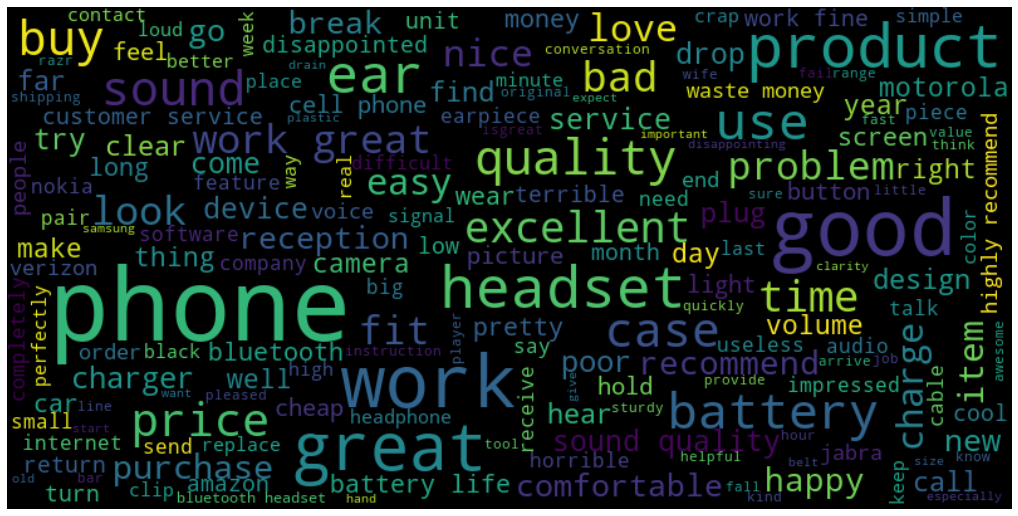

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 667)

wordcloud.generate(cleaned)

plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

In [49]:
X = df['reviews'] # FEATURES
y = df['sentiment'] # TARGET

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

X_ = vectorizer.fit_transform(X).toarray()
X_

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [51]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_ = tfidfconverter.fit_transform(X_).toarray()
X_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.38863708,
        0.        ]])

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [53]:
labels = ['Negative', 'Positive']

###RANDOMFOREST

In [54]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=667,max_depth=5)
classifier.fit(X_train, y_train) 

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=667)

In [55]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7


Text(69.0, 0.5, 'Actual')

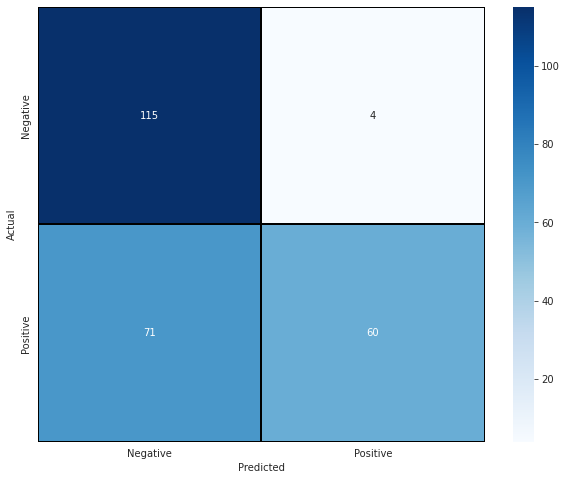

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [57]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.62      0.97      0.75       119
    Positive       0.94      0.46      0.62       131

    accuracy                           0.70       250
   macro avg       0.78      0.71      0.68       250
weighted avg       0.79      0.70      0.68       250



In [58]:
!pip install plot-metric --quiet

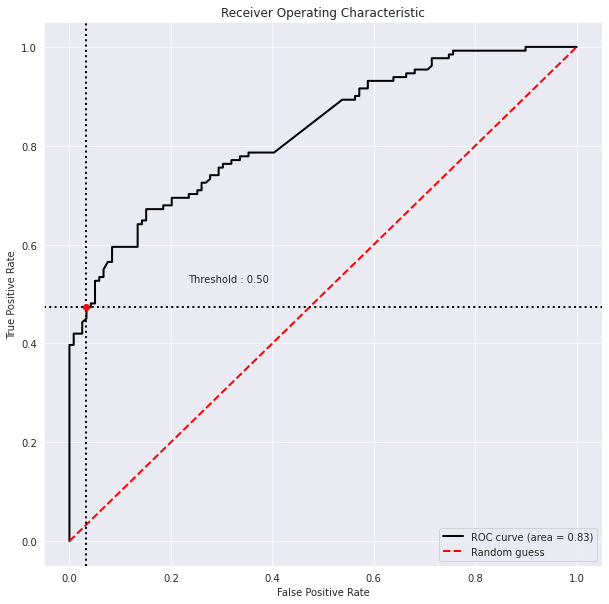

In [59]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

###MULTINOMIAL NB

In [60]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In [61]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.736


Text(69.0, 0.5, 'Actual')

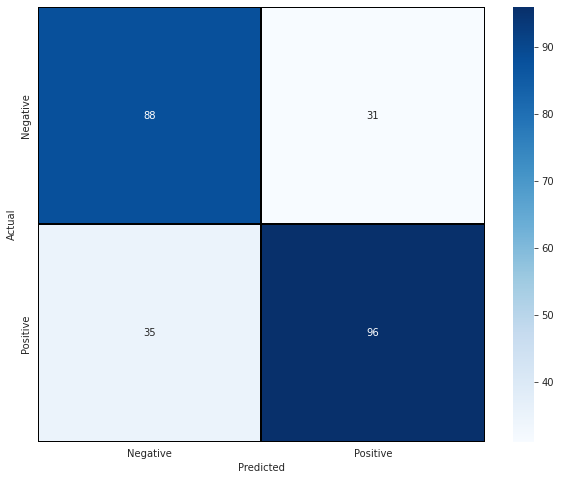

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [63]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.72      0.74      0.73       119
    Positive       0.76      0.73      0.74       131

    accuracy                           0.74       250
   macro avg       0.74      0.74      0.74       250
weighted avg       0.74      0.74      0.74       250



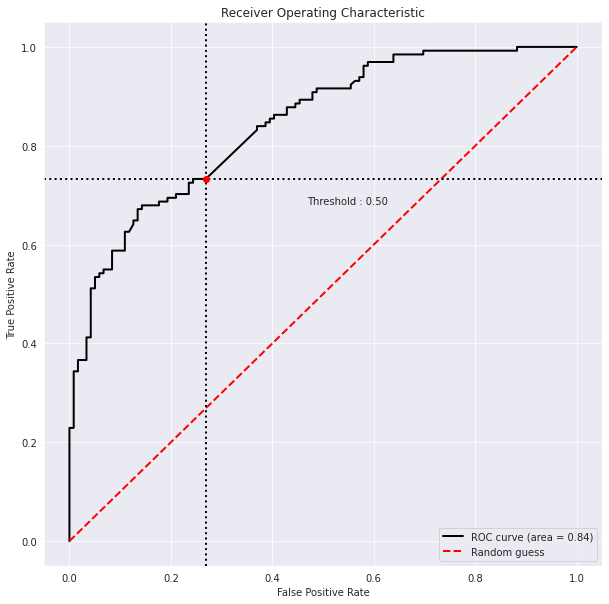

In [64]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

###SGD CLASSIFIER

In [65]:
# accuracy score on the test data
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=667, max_iter=5, tol=None)
classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.752


Text(69.0, 0.5, 'Actual')

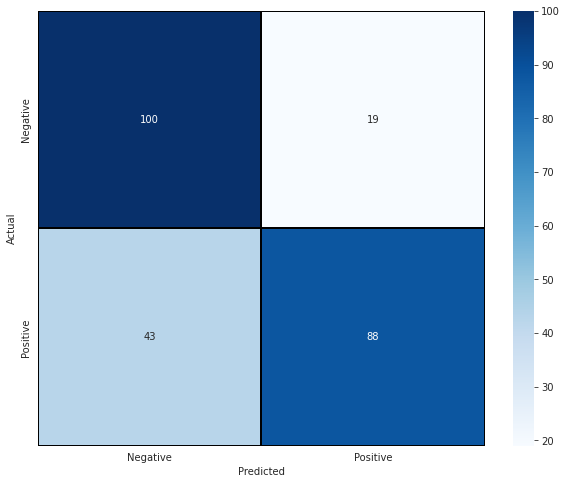

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [67]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.70      0.84      0.76       119
    Positive       0.82      0.67      0.74       131

    accuracy                           0.75       250
   macro avg       0.76      0.76      0.75       250
weighted avg       0.76      0.75      0.75       250



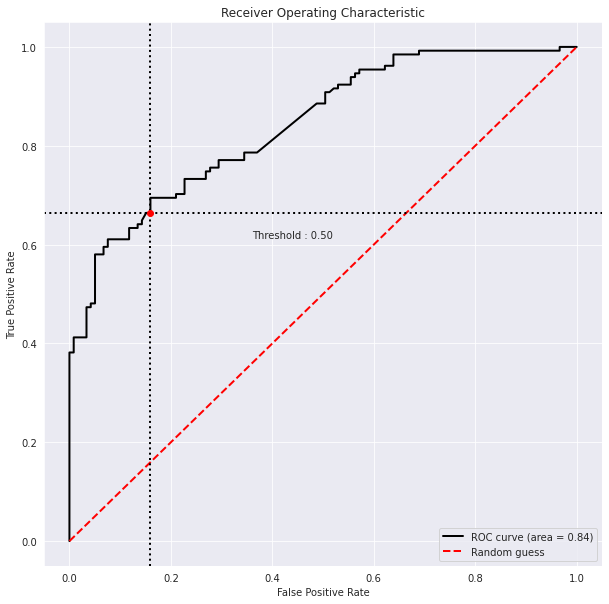

In [68]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

###PIPELINE

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [70]:
from sklearn.pipeline import Pipeline

text_preprocess = TextPreprocessor(n_jobs=-1)
bow = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
tfidf = TfidfTransformer()
classifier = SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=667, max_iter=5, tol=None)

pipe = Pipeline([
                ('lemma_stop_rem',text_preprocess),
                ('bow',bow),
                ('tfidf',tfidf),
                ('clf',classifier),
                ])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)
test_data_accuracy = accuracy_score( y_test,predicted)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.724


In [71]:
test = pd.Series({'text':'the beer is finished'})

In [72]:
prediction = pipe.predict(test)
print(prediction[0])

if (prediction[0] == 0):
  print('Negative')
else:
  print('Positive')

0
Negative


In [73]:
import joblib

joblib.dump(pipe,'pipeline_classifier_SpaCy.pkl')

['pipeline_classifier_SpaCy.pkl']